<a href="https://colab.research.google.com/github/haleywis/OPTI556/blob/main/HW3_Wiskoski_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OPTI-556: Computational Imaging**  
# Haley Wiskoski  
Homework #3 - Rays   
Due: Thursday October 7, 2021
Part 3: Projection Tomography

In [7]:
# Python Modules
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from skimage.transform import radon, rescale,  resize, warp
from scipy import interpolate
from skimage.transform import iradon_sart
from progressbar import ProgressBar

## 3) Neural Reconstruction of Radon Data

/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


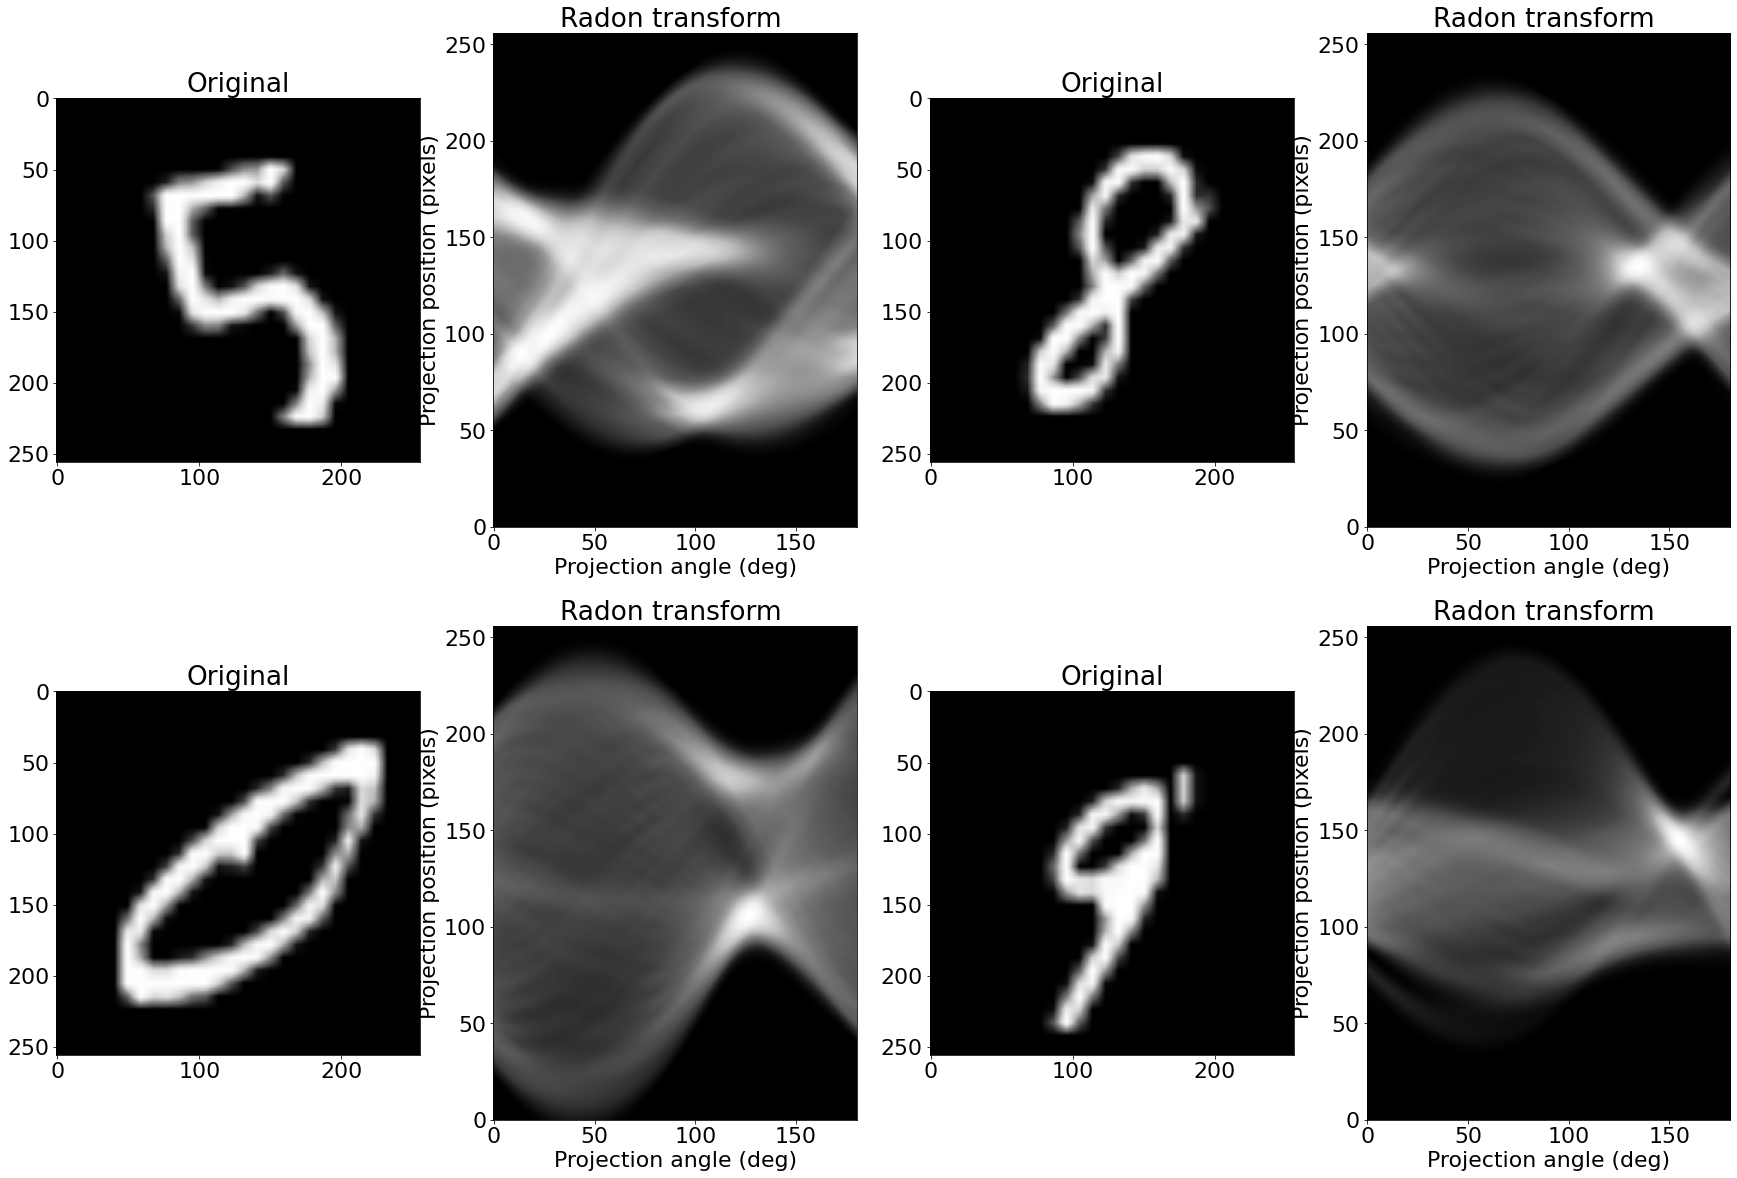

In [3]:
# code from https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html


fig, ax = plt.subplots(2, 4, figsize=(30, 20))
nP=256
image=x_train[1024,:,:]
image = resize(image, (nP,nP), mode='edge')
ax[0,0].set_title("Original")
ax[0,0].imshow(image, cmap=plt.cm.Greys_r)
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax[0,1].set_title("Radon transform ")
ax[0,1].set_xlabel("Projection angle (deg)")
ax[0,1].set_ylabel("Projection position (pixels)")
ax[0,1].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')
image=x_train[1025,:,:]
image = resize(image, (nP,nP), mode='edge')
ax[0,2].set_title("Original")
ax[0,2].imshow(image, cmap=plt.cm.Greys_r)
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax[0,3].set_title("Radon transform ")
ax[0,3].set_xlabel("Projection angle (deg)")
ax[0,3].set_ylabel("Projection position (pixels)")
ax[0,3].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')
image=x_train[1029,:,:]
image = resize(image, (nP,nP), mode='edge')
ax[1,0].set_title("Original")
ax[1,0].imshow(image, cmap=plt.cm.Greys_r)
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax[1,1].set_title("Radon transform ")
ax[1,1].set_xlabel("Projection angle (deg)")
ax[1,1].set_ylabel("Projection position (pixels)")
ax[1,1].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')
image=x_train[1027,:,:]
image = resize(image, (nP,nP), mode='edge')
ax[1,2].set_title("Original")
ax[1,2].imshow(image, cmap=plt.cm.Greys_r)
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax[1,3].set_title("Radon transform ")
ax[1,3].set_xlabel("Projection angle (deg)")
ax[1,3].set_ylabel("Projection position (pixels)")
ax[1,3].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

### Modified iradon function

In [6]:
from scipy.interpolate import interp1d
from scipy.constants import golden_ratio
from skimage.transform._warps import warp
from skimage.transform._radon_transform import sart_projection_update
from skimage._shared.fft import fftmodule
from skimage._shared.utils import  convert_to_float
from warnings import warn
from functools import partial

if fftmodule is np.fft:
    # fallback from scipy.fft to scipy.fftpack instead of numpy.fft
    # (fftpack preserves single precision while numpy.fft does not)
    from scipy.fftpack import fft, ifft
else:
    fft = fftmodule.fft
    ifft = fftmodule.ifft
    
def iradon(radon_image, theta=None, output_size=None,
           filter_name="ramp", interpolation="linear", circle=True,
           preserve_range=True):
    if radon_image.ndim != 2:
        raise ValueError('The input image must be 2-D')

    if theta is None:
        theta = np.linspace(0, 180, radon_image.shape[1], endpoint=False)

    angles_count = len(theta)
    if angles_count != radon_image.shape[1]:
        raise ValueError("The given ``theta`` does not match the number of "
                         "projections in ``radon_image``.")

    interpolation_types = ('linear', 'nearest', 'cubic')
    if interpolation not in interpolation_types:
        raise ValueError("Unknown interpolation: %s" % interpolation)

    filter_types = ('ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None)
    if filter_name not in filter_types:
        raise ValueError("Unknown filter: %s" % filter_name)

    radon_image = convert_to_float(radon_image, preserve_range)
    dtype = radon_image.dtype

    img_shape = radon_image.shape[0]
    if output_size is None:
        # If output size not specified, estimate from input radon image
        if circle:
            output_size = img_shape
        else:
            output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

    if circle:
        radon_image = _sinogram_circle_to_square(radon_image)
        img_shape = radon_image.shape[0]

    # Resize image to next power of two (but no less than 64) for
    # Fourier analysis; speeds up Fourier and lessens artifacts
    projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * img_shape))))
    pad_width = ((0, projection_size_padded - img_shape), (0, 0))
    img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

    # Apply filter in Fourier domain
    fourier_filter = _get_fourier_filter(projection_size_padded, filter_name)
    projection = fft(img, axis=0) * fourier_filter
    radon_filtered = np.real(ifft(projection, axis=0)[:img_shape, :])

    # Reconstruct image by interpolation
    reconstructed = np.zeros((output_size, output_size),
                             dtype=dtype)
    radius = output_size // 2
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape) - img_shape // 2

    for col, angle in zip(radon_filtered.T, np.deg2rad(theta)):
        t = ypr * np.cos(angle) - xpr * np.sin(angle)
        if interpolation == 'linear':
            interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
        else:
            interpolant = interp1d(x, col, kind=interpolation,
                                   bounds_error=False, fill_value=0)
        reconstructed += interpolant(t)

    if circle:
        out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
        reconstructed[out_reconstruction_circle] = 0.
    return reconstructed * np.pi / (2 * angles_count), projection

def _sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)
def _get_fourier_filter(size, filter_name):
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=int),
                        np.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = np.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2

    # Computing the ramp filter from the fourier transform of its
    # frequency domain representation lessens artifacts and removes a
    # small bias as explained in [1], Chap 3. Equation 61
    fourier_filter = 2 * np.real(fft(f))         # ramp filter
    if filter_name == "ramp":
        pass
    elif filter_name == "shepp-logan":
        # Start from first element to avoid divide by zero
        omega = np.pi * fftmodule.fftfreq(size)[1:]
        fourier_filter[1:] *= np.sin(omega) / omega
    elif filter_name == "cosine":
        freq = np.linspace(0, np.pi, size, endpoint=False)
        cosine_filter = fftmodule.fftshift(np.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == "hamming":
        fourier_filter *= fftmodule.fftshift(np.hamming(size))
    elif filter_name == "hann":
        fourier_filter *= fftmodule.fftshift(np.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1

    return fourier_filter[:, np.newaxis]

#### Load and Prep Data

In [8]:
# Loading MNIST dataset of written characters
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

In [9]:
ntheta = 20;
thetaVals =np.random.choice(360,ntheta,replace=False)/2.
g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))

pbar1 = ProgressBar()
for pop in pbar1(range(np.shape(x_test)[0])):
  g_test[pop,:,:]= iradon_sart(radon(x_test[pop,:,:],thetaVals), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])

pbar2 = ProgressBar()
for pop in pbar2(range(np.shape(x_train)[0])):
  g_train[pop,:,:]=iradon_sart(radon(x_train[pop,:,:],thetaVals), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

N/A% (0 of 10000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
100% (10000 of 10000) |##################| Elapsed Time: 0:02:21 Time:  0:02:21
100% (60000 of 60000) |##################| Elapsed Time: 0:13:56 Time:  0:13:56


In [10]:
np.save('xtrain2',x_train)
np.save('xtest2',x_test)
np.save('gtrain2', g_train)
np.save('gtest2', g_test)